# LIM forecasting: multivariate separate sic

Katie Brennan  
started March 31, 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [2]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
nmodes_sic = 60

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.4

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
limvars = ['tas','tos','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sic']
nvars = len(limvars)

# specify the model source 
dsource = 'ccsm4_lm'

# select 2 variables for analysis and plotting
var_dict = {}

sic_separate = True

In [3]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [4]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration',
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [6]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [7]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

In [8]:
import importlib
importlib.reload(lim)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [9]:
import time as timestamp # avoids conflict with local naming!

In [10]:
dsource

'ccsm4_lm'

In [11]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = lim.build_training_dic(dsource)
fdic_mpi = lim.build_training_dic('mpi_lm')

In [12]:
#----------- end of function definitions --------------

In [13]:

data, data_var, vardimnames, time_yrs = lim.load_data('sic',fdic_ccsm4['sic'])
ntime, lat_2d_orig, lon_2d_orig = lim.set_coord_names(data, data_var, vardimnames, 'sic')
data_new, lat_2d, lon_2d = lim.regrid_data(data_var, ntime, lat_2d_orig, lon_2d_orig, 91,180)


fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 1.9726154804229736 seconds
-----------------------------------------------------
(12012, 180, 360)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 180
nlon: 360
(64800, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 5.648784875869751 seconds
-----------------------------------------------------


In [14]:
#
# load CCSM4 past1000 data...
#
for k, var in enumerate(limvars): 
    print('Loading '+var)
    data_in,lat_2d,lon_2d, time_yrs = lim.get_data(var,fdic_ccsm4[var], 91, 180)
    ntime = data_in.shape[0]
    nlat = data_in.shape[1]
    nlon = data_in.shape[2]
    X_var = np.moveaxis(np.reshape(data_in,[ntime,nlat*nlon]),0,-1) 
    if k == 0: 
        X_all = np.zeros((nvars,nlat*nlon,ntime))
    X_all[k,:,:] = X_var

Loading tas
fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 2.1666488647460938 seconds
-----------------------------------------------------
(12012, 192, 288)
indlat= 0  indlon= 1
('lat', 'lon')
regridding data...
nlat: 192
nlon: 288
(55296, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 5.259761095046997 seconds
-----------------------------------------------------
Removing climo from:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11
Loading tos
fetching  tos  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tos_sfc_Omon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 79.30219221115112 seconds
----------------------------------

In [15]:
# combine fields in the row space into a full state vector
if nvars > 1:
    for k in range(nvars-1):
        if k == 0:
            X = np.concatenate((X_all[0],X_all[1]),axis=0)
        else:
            X = np.concatenate((X,X_all[k+1]),axis=0)
else:
    X = np.squeeze(np.copy(X_all))
    
print(X.shape)

(49140, 12012)


In [16]:
X_all.shape

(3, 16380, 12012)

In [17]:
# set location indices for each variable
ndof = X_all[0,:].shape[0]

# dictionary with the field info
fields = OrderedDict()
for k,var in enumerate(limvars):
    d = {}
    var_inds = np.arange(k*ndof,(k+1)*ndof)
    fields[limvars[k]] = var_inds
    d['varind'] = k
    d['var_inds'] = var_inds
    var_dict[var] = d
        
print(fields.keys())

odict_keys(['tas', 'tos', 'sic'])


In [18]:
X.shape

(49140, 12012)

In [19]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

X_train = X_all[:,:,train_inds]
X_valid = X_all[:,:,valid_inds]
truth = X[:,valid_inds]
yrs_train = time_yrs[train_inds]
yrs_valid = time_yrs[valid_inds]

print('training data shape: ',X_train.shape)
print('validation data shape: ',X_valid.shape)

training data shape:  (3, 16380, 4800)
validation data shape:  (3, 16380, 7212)


In [20]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
tmp = np.sqrt(np.cos(np.radians(lat_2d)))
W = np.reshape(tmp,[nlat*nlon,1])
# note W*X = X*W

if sic_separate is True: 
    E3 = np.zeros([ndof*(nvars-1),ntrunc*(nvars-1)])
else:  
    E3 = np.zeros([ndof*(nvars),ntrunc*(nvars)])
n=0
for k,var in enumerate(limvars):
    print('decomposing...',var)
    u,s,v = np.linalg.svd(W*np.nan_to_num(X_train[k,:,:]),full_matrices=False)
    fvar = 100*s*s/np.sum(s*s)
    if (sic_separate is True) & (var is 'sic'):
        print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:nmodes_sic]))
    else: 
        print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:ntrunc]))

    # projection
    P_var = np.matmul(u[:,:ntrunc].T,np.nan_to_num(X_train[k,:,:]))
    standard_factor = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))

    if k == 0:
        Ptrunc = P_var/standard_factor
        
        # reverse operator from EOFs to grid point space
        E3[k*ndof:(k+1)*ndof,k*ntrunc:(k+1)*ntrunc] = u[:,:ntrunc]
        n=n+1
    elif (sic_separate is True) & (var is 'sic'):
        print('...separately')
        Ptrunc_sic = np.matmul(u[:,:nmodes_sic].T,np.nan_to_num(X_train[k,:,:]))/standard_factor
        E_sic = u[:,:nmodes_sic]
    else:
        Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor),axis=0)
      
        # reverse operator from EOFs to grid point space
        E3[n*ndof:(n+1)*ndof,n*ntrunc:(n+1)*ntrunc] = u[:,:ntrunc]
        n=n+1
    
# truncate the coupled covariance matrix
U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc = U[:,0:nmodes]
P = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E = np.matmul(E3,Etrunc)
print(E.shape)

if sic_separate is True: 
    P_train = np.concatenate((P,Ptrunc_sic),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_train = P

decomposing... tas
fraction in first 400 tas EOFs =  94.21248230149992
decomposing... tos
fraction in first 400 tos EOFs =  94.60987562613008
decomposing... sic
fraction in first 60 sic EOFs =  63.51199936115708
...separately
(32760, 60)


In [21]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train

if sic_separate is True: 
    nonsic = np.reshape(X_valid[:-1,:,:],((len(limvars)-1)*ndof,X_valid.shape[2]))
    x_valid_nonsic = np.matmul(E.T,np.nan_to_num(nonsic))
    x_valid_sic = np.matmul(E_sic.T,np.nan_to_num(X_valid[-1,:,:]))
    x_valid = np.concatenate((x_valid_nonsic,x_valid_sic),axis=0)
else: 
    X_valid_rs = np.reshape(X_valid,(len(limvars)*ndof,X_valid.shape[2]))
    x_valid =  np.matmul(E.T,np.nan_to_num(X_valid_rs))
yrs_train = time_yrs[train_inds]
yrs_valid = time_yrs[valid_inds]

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (120, 4800)
validation data shape:  (120, 7212)


In [22]:
x_valid.shape

(120, 7212)

In [23]:
# climo standardized variance for error normalization 
#  in training and validation (1=no skill)
# EOF space only
if sic_separate is True: 
    E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
    E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E,E_sic)

else: 
    E_x_train = np.matmul(E,x_train)
    E_x_valid = np.matmul(E,x_valid)

E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
nyrs_train = int(E_x_train.shape[1]/12)
nyrs_valid = int(E_x_valid.shape[1]/12)
nlalo = E_x_train.shape[0]

train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
                       axis=1,ddof=1)
valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
                       axis=1,ddof=1)
train_var = np.nanvar(E_x_train,axis=1,ddof=1)
valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# FULL FIELD versions of the variance 
train_var_full = np.nanvar(X[:,train_inds],axis=1,ddof=1)
valid_var_full = np.nanvar(X[:,valid_inds],axis=1,ddof=1)

valid_var_mon_full = np.var(np.reshape(X[:,valid_inds],(nvars*ndof,nyrs_valid,12)),
                            axis=1,ddof=1)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.


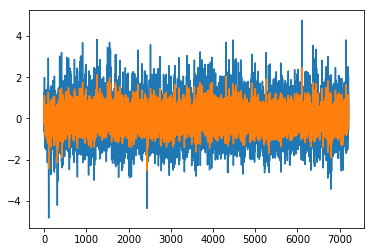

In [24]:
plt.plot(truth[0,:])
plt.plot(E_x_valid[0,:])

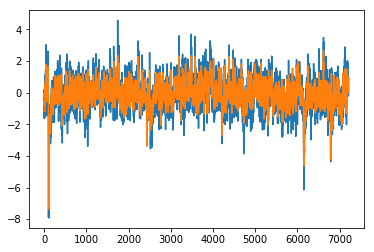

In [25]:
plt.plot(truth[9702,:])
plt.plot(E_x_valid[9702,:])

In [26]:
# valid_variance_eof = lim.calc_gm_polar_variance(valid_var,valid_var_mon,
#                                                 fields,lat_2d[:,0],lon_2d[0,:])
# valid_variance_full = lim.calc_gm_polar_variance(valid_var_full,valid_var_mon_full,
#                                                  fields,lat_2d[:,0],lon_2d[0,:])

# for v,var in enumerate(limvars):
#     print(var)
# #    valid_variance_eof[var+'_lalo'] = np.reshape(valid_var[fields[var]],[nlat,nlon])
#     valid_variance_full[var+'_lalo'] = np.reshape(valid_var_full[fields[var]],[nlat,nlon])
# #    valid_variance_eof[var+'_mon_lalo'] = np.reshape(valid_var_mon[fields[var]],
# #                                                     [nlat,nlon,12])
#     valid_variance_full[var+'_mon_lalo'] = np.reshape(valid_var_mon_full[fields[var]],
#                                                       [nlat,nlon,12])

In [27]:
# # climo mean and covariance in EOF space sampled over all times
# Pm = np.mean(P,axis=1,keepdims=True)
# tmp = P - Pm
# Cc = np.matmul(tmp,tmp.T)/(tmp.shape[1]-1)

In [28]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [29]:
#LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
#lags = np.arange(13)
lags = [0,12,24]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
truth = X[:,valid_inds]
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic,
                                    sic_separate=sic_separate)

t= 0
t= 12
t= 24


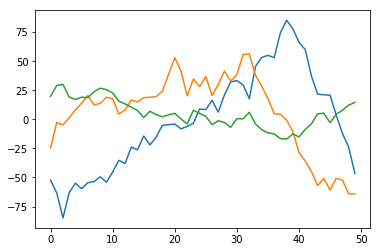

In [39]:
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][0,0,:50])
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][1,0,12:62])
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][2,0,24:74])

In [30]:
truth_state = lim.calc_lags_gm_pm(truth, lat_2d[:,0], lon_2d[0,:], fields, 
                                  valid_inds.shape[0],lags, limvars)

working on tas
working on tos
working on sic


In [74]:
forecast= lim.calc_lags_gm_pm(LIMfd_valid['x_forecast'], lat_2d[:,0], lon_2d[0,:], 
                              fields, valid_inds.shape[0], lags, limvars, 
                              decompress=True, E=E, E_sic=E_sic,Nmodes=nmodes,
                              Nmodes_sic=nmodes_sic,sic_separate=sic_separate)

working on tas
working on psl
working on tos
working on sic


In [77]:
ce, corr = lim.calc_ce_corr_lags_gm_pm(truth_state[0],forecast[0],limvars,lags)

working on tas
working on psl
working on tos
working on sic


In [80]:
ce_ar1, corr_ar1 = lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                            lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [76]:
lag = 12
v=0
lat = lat_2d[:,0]
lon = lon_2d[0,:]
ar1_forecast, factor = lim.red_noise_forecast_ar1(X_train[v,:].T,X_valid[v,:].T,lead=lag)
ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
X_valid_3d = np.reshape(X_valid[v,:].T,(X_valid.shape[2],nlat,nlon))
ar1_gm,_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
valid_gm,_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)

In [77]:
ar1_forecast.shape, factor.shape, X_valid[v,:].T.shape

((7200, 16380), (16380,), (7212, 16380))

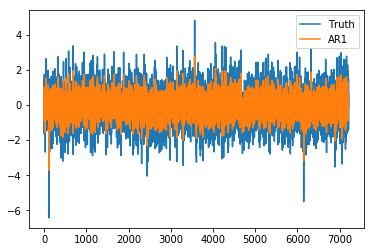

In [82]:
plt.plot(X_valid[v,:].T[:,16000], label='Truth')
plt.plot(ar1_forecast[:,16000]*50, label='AR1')
#plt.xlim(50,150)
plt.legend()

In [65]:
X_valid[v,:].shape, ar1_forecast_3d.shape, X_valid_3d.shape

((16380, 7212), (7200, 91, 180), (7212, 91, 180))

In [ ]:
X_train[v,:].T.shape

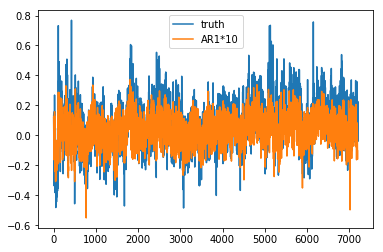

In [64]:
plt.plot(true_gm, label='truth')
plt.plot(ar1_gm*10, label='AR1*10')
#plt.xlim(50,150)
plt.legend()

#### Check standardization:

In [51]:
drs = np.reshape(data_new,(91*180,1001,12))
dmn = np.nanmean(drs,axis=1)
danom1 = drs-dmn[:,np.newaxis,:]
dstd = np.std(drs,axis=1,ddof=1)
dstand = danom1/dstd[:,np.newaxis,:]

dstandard = np.reshape(dstand,(91*180,12012))

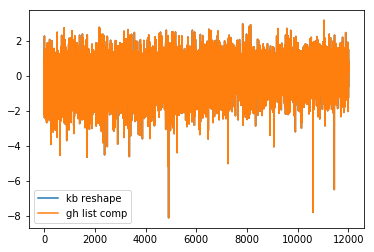

In [57]:
plt.plot(dstandard[1171,:], label='kb reshape')
plt.plot(X_all[2,1171,:], label='gh list comp')
plt.legend()

In [46]:
m=3
ind = [j for j,v in enumerate(time_yrs) if v.month == m]

In [64]:
np.reshape(time_yrs,(1001,12))[:,0]

array([cftime._cftime.DatetimeNoLeap(850, 1, 16, 12, 0, 0, 0, 6, 16),
       cftime._cftime.DatetimeNoLeap(851, 1, 16, 12, 0, 0, 0, 0, 16),
       cftime._cftime.DatetimeNoLeap(852, 1, 16, 12, 0, 0, 0, 1, 16), ...,
       cftime._cftime.DatetimeNoLeap(1848, 1, 16, 12, 0, 0, 0, 3, 16),
       cftime._cftime.DatetimeNoLeap(1849, 1, 16, 12, 0, 0, 0, 4, 16),
       cftime._cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, 5, 16)],
      dtype=object)

In [227]:
dumb = np.arange(0,12012,1)

In [236]:
np.allclose(ind,np.reshape(dumb,(1001,12))[:,2])

True

In [59]:
dvalid = danom[:,4800:]
dtrain = danom[:,0:4800]

dvalidst = dstandard[:,4800:]
dtrainst = dstandard[:,0:4800]

NameError: name 'danom' is not defined

In [154]:
danom.shape, dat

(3240, 12012)

In [58]:
lag = 12
v=2
lat = lat_2d[:,0]
lon = lon_2d[0,:]
ar1_forecast, factor = lim.red_noise_forecast_ar1(dtrainst.T,dvalidst.T,lead=lag)
ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],45,72))
X_valid_3d = np.reshape(dvalid.T,(X_valid.shape[2],45,72))
ar1_gm,_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
valid_gm,_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)

NameError: name 'dtrainst' is not defined

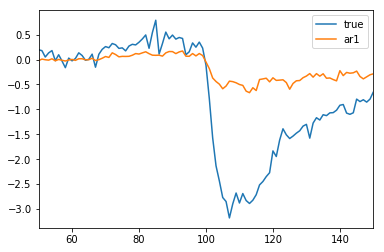

In [181]:
plt.plot(true_gm, label='true')
plt.plot(ar1_gm*10, label='ar1')
plt.xlim(50,150)
plt.legend()

In [139]:
X_valid.shape[2]

7212

In [121]:
lac = lim.calc_lac(X_train[v,:-12].T, X_train[v,12:].T)

In [134]:
lac2 = lim.calc_lac(dtrain[:,:-12].T, dtrain[:,12:].T)

In [177]:
ce_gm = LMR_utils.coefficient_efficiency(true_gm[24:],ar1_gm*10)
corr_gm = np.corrcoef(true_gm[24:],ar1_gm*10)[0,1]
ce_gm, corr_gm

(-0.35755117229944244, -0.05897322952193973)

In [169]:
ce_gm, corr_gm

(0.1657429236460345, 0.5371374452747459)

In [166]:
ce_gm, corr_gm

(0.29168524590382205, 0.5598192850433341)

In [ ]:
plt.plot(truth_state[0]['sit_pm'][1,0,:], label='truth')
plt.plot(forecast[0]['sit_pm'][1,0,:]*2, label='forecast')
plt.xlim(0,100)
plt.legend()

In [ ]:
for l in range(12):
    print(LMR_utils.coefficient_efficiency(truth_state[0]['sit_pm'][l,0,l:],
                                     forecast[0]['sit_pm'][l,0,l:]))

In [ ]:
LMR_utils.coefficient_efficiency(truth_state[0]['sit_pm'][1,0,:],
                                 forecast[0]['sit_pm'][1,0,:])

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

### Plotting: 

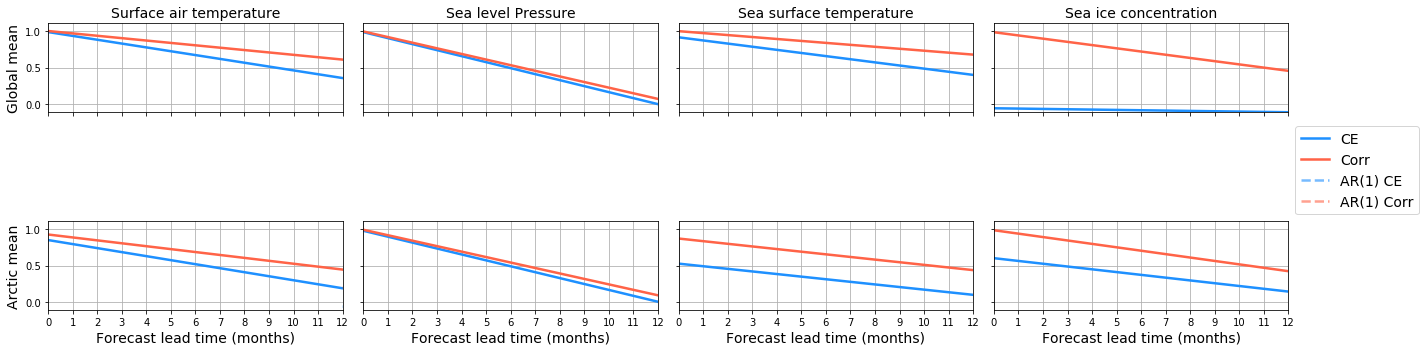

In [81]:
color_list = ['tomato','dodgerblue','m','c','orange','k']

fig,ax = plt.subplots(2,len(limvars), figsize=(len(limvars)*5,5),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(limvars): 
    ax[n].plot(lags,ce[var+'_gm'],color=color_list[1],
             linestyle='-',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_gm'],color=color_list[0],
             linestyle='-',linewidth=2.5)
    ax[n+len(limvars)].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n+len(limvars)].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(limvars): 
    ax[n].plot(lags[1:],ce_ar1[var+'_gm'][1:],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(lags[1:],corr_ar1[var+'_gm'][1:],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(limvars)].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(limvars)].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(limvars)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(limvars),len(limvars)*2,1):
    ax[n].set_xlabel('Forecast lead time (months)', fontsize=14)
    ax[n].set_xticks(np.arange(0,13,1))

for n,var in enumerate(limvars):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(limvars)):
    ax[n].grid(which='both')
    ax[n].set_xlim(0,12)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

#ax[7].legend(loc='upper right', fontsize=14)
ax[-1].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

save_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/results/multivariate_sens_testing/'
save_name = ('ce_corr_lags_lim_'+str(dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
#plt.savefig((save_dir+save_name),dpi=300)

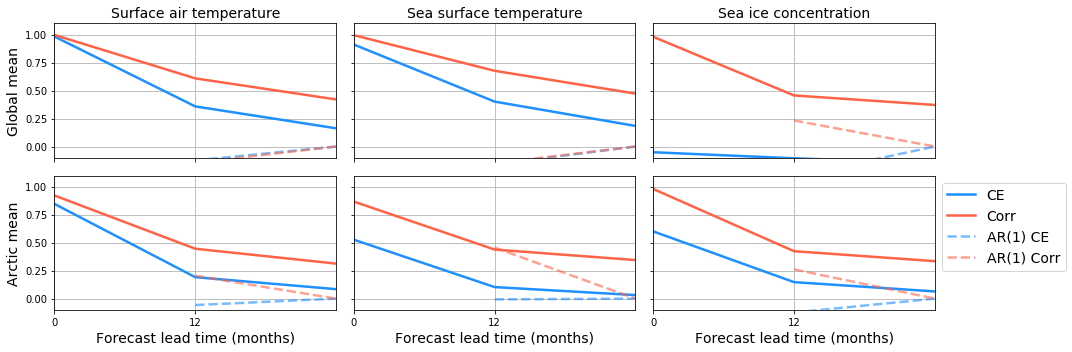

In [83]:
color_list = ['tomato','dodgerblue','m','c','orange','k']
varplot = ['tas','tos','sic']

fig,ax = plt.subplots(2,len(varplot), figsize=(len(varplot)*5,5),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    ax[n].plot(lags,ce[var+'_gm'],color=color_list[1],
             linestyle='-',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_gm'],color=color_list[0],
             linestyle='-',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(lags[1:],ce_ar1[var+'_gm'][1:],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(lags[1:],corr_ar1[var+'_gm'][1:],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(varplot)].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(varplot)].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(varplot)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(varplot),len(varplot)*2,1):
    ax[n].set_xlabel('Forecast lead time (months)', fontsize=14)
    ax[n].set_xticks(np.arange(0,24,12))

for n,var in enumerate(varplot):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(0,24)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

ax[-1].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

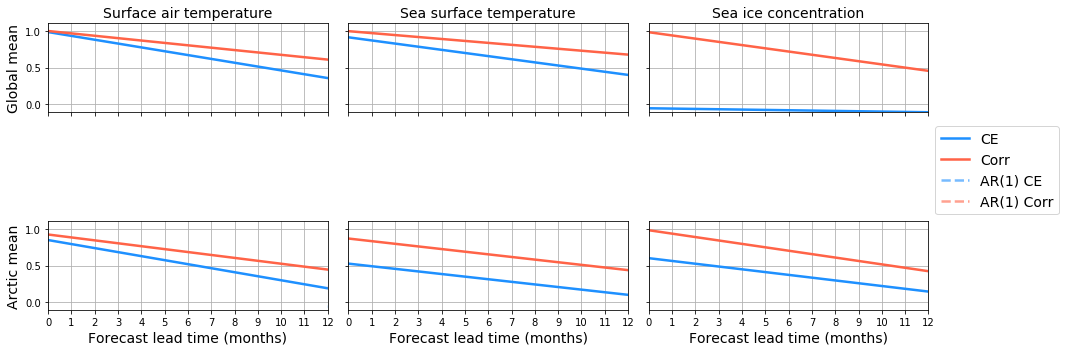

In [82]:
color_list = ['tomato','dodgerblue','m','c','orange','k']
varplot = ['tas','tos','sic']

fig,ax = plt.subplots(2,len(varplot), figsize=(len(varplot)*5,5),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    ax[n].plot(lags,ce[var+'_gm'],color=color_list[1],
             linestyle='-',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_gm'],color=color_list[0],
             linestyle='-',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(lags[1:],ce_ar1[var+'_gm'][1:],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(lags[1:],corr_ar1[var+'_gm'][1:],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(varplot)].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(varplot)].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(varplot)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(varplot),len(varplot)*2,1):
    ax[n].set_xlabel('Forecast lead time (months)', fontsize=14)
    ax[n].set_xticks(np.arange(0,13,1))

for n,var in enumerate(varplot):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(0,12)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

ax[-1].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

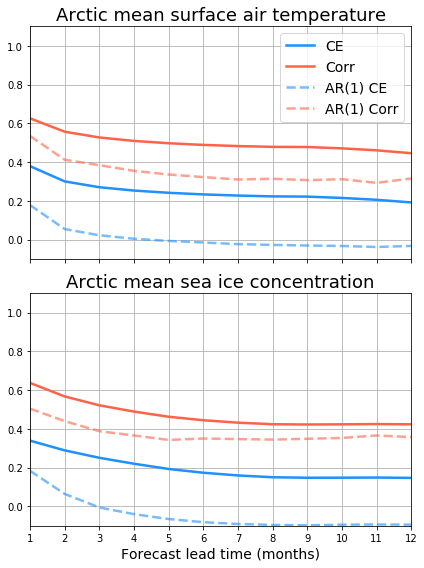

In [65]:
color_list = ['tomato','dodgerblue','m','c','orange','k']
varplot = ['tas','sic']

fig,ax = plt.subplots(len(varplot),1, figsize=(6,8),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    ax[n].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_title('Arctic mean s'+full_names[varplot[0]][1:], fontsize=18)
ax[1].set_title('Arctic mean s'+full_names[varplot[1]][1:], fontsize=18)

for n,var in enumerate(varplot):
#    ax[n].set_ylabel(full_names[var], fontsize=14)
    ax[n].set_xticks(np.arange(0,13,1))
    
ax[-1].set_xlabel('Forecast lead time (months)', fontsize=14)

for n in range(len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

ax[0].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

## Monthly performance: 

In [37]:
ce_monthly = {}
corr_monthly = {}
l = 1

for n,var in enumerate(limvars): 
    ce_pm_mon = np.zeros((12,2))
    corr_pm_mon = np.zeros((12,2))
    ce_gm_mon = np.zeros((12))
    corr_gm_mon = np.zeros((12))
    
    truth_state_mon_gm = np.reshape(truth_state[0][var+'_gm'][1,12:],(nyrs_valid-1,12))
    forecast_mon_gm = np.reshape(forecast[0][var+'_gm'][1,12:],(nyrs_valid-1,12))
    truth_state_mon_pm = np.reshape(truth_state[0][var+'_pm'][1,:,12:],(2,nyrs_valid-1,12))
    forecast_mon_pm = np.reshape(forecast[0][var+'_pm'][1,:,12:],(2,nyrs_valid-1,12))

    for mon in range(12):
        ce_gm_mon[mon] = LMR_utils.coefficient_efficiency(truth_state_mon_gm[:,mon],
                                                          forecast_mon_gm[:,mon])
        corr_gm_mon[mon] = np.corrcoef(truth_state_mon_gm[:,mon],
                                     forecast_mon_gm[:,mon])[0,1]

        for m in range(2):
            ce_pm_mon[mon,m] = LMR_utils.coefficient_efficiency(truth_state_mon_pm[m,:,mon],
                                                              forecast_mon_pm[m,:,mon])
            corr_pm_mon[mon,m] = np.corrcoef(truth_state_mon_pm[m,:,mon],
                                           forecast_mon_pm[m,:,mon])[0,1]

    ce_monthly[var+'_pm'] = ce_pm_mon
    corr_monthly[var+'_pm'] = corr_pm_mon
    ce_monthly[var+'_gm'] = ce_gm_mon
    corr_monthly[var+'_gm'] = corr_gm_mon

In [38]:
ce_mon_ar1, corr_mon_ar1 = lim.calc_ce_corr_ar_mon(X_valid,X_train,1,limvars,lat_2d[:,0],
                                                   lon_2d[0,:])

tas
psl
tos
sic


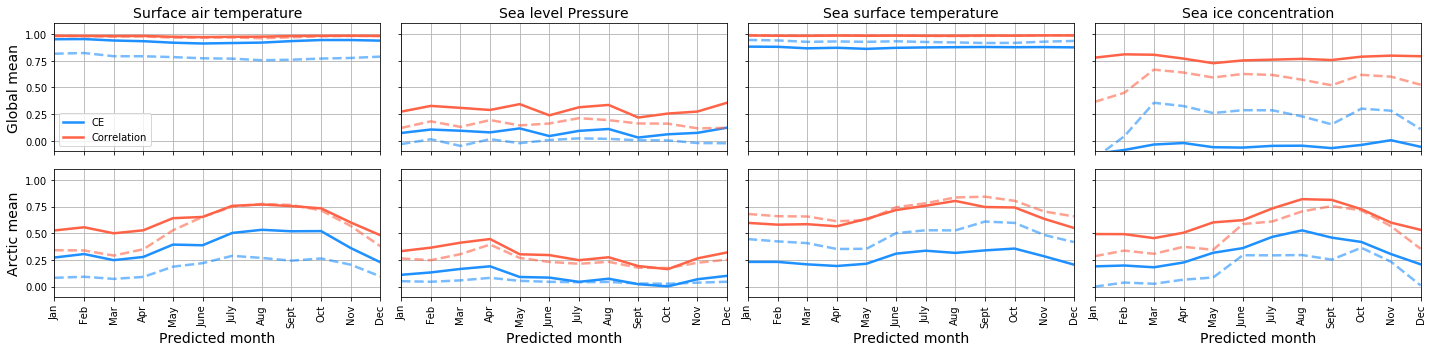

In [39]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig,ax = plt.subplots(2,len(limvars), figsize=(len(limvars)*5,5),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(limvars): 
    print(var)
    ax[n].plot(np.arange(1,13,1),ce_monthly[var+'_gm'],color=color_list[1],
             linestyle='-', label='CE', linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_monthly[var+'_gm'],color=color_list[0],
             linestyle='-', label='Correlation', linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),ce_monthly[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),corr_monthly[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', linewidth=2.5)
    
for n,var in enumerate(limvars): 
    ax[n].plot(np.arange(1,13,1),ce_mon_ar1[var+'_gm'],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_mon_ar1[var+'_gm'],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),ce_mon_ar1[var+'_pm'][:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(limvars)].plot(np.arange(1,13,1),corr_mon_ar1[var+'_pm'][:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(limvars)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(limvars),len(limvars)*2,1):
    ax[n].set_xlabel('Predicted month', fontsize=14)
    ax[n].set_xticks(np.arange(1,13,1))
    ax[n].set_xticklabels(mlabels, rotation=90)

for n,var in enumerate(limvars):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(limvars)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)

ax[0].legend(loc='lower left')
plt.tight_layout()

save_name = ('ce_corr_mon_lim_'+str(dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
plt.savefig((save_dir+save_name),dpi=300)

tas
sic


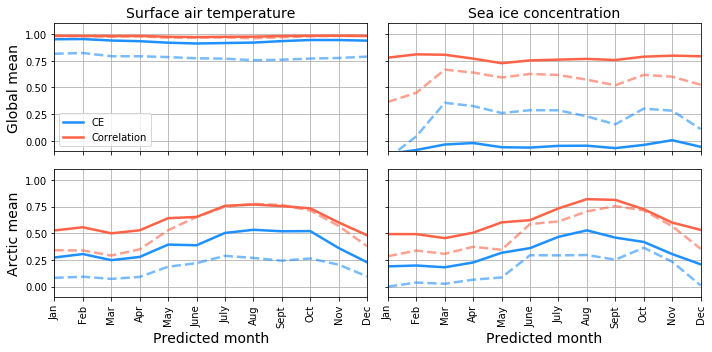

In [40]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig,ax = plt.subplots(2,len(varplot), figsize=(len(varplot)*5,5),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    print(var)
    ax[n].plot(np.arange(1,13,1),ce_monthly[var+'_gm'],color=color_list[1],
             linestyle='-', label='CE', linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_monthly[var+'_gm'],color=color_list[0],
             linestyle='-', label='Correlation', linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),ce_monthly[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),corr_monthly[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(np.arange(1,13,1),ce_mon_ar1[var+'_gm'],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_mon_ar1[var+'_gm'],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),ce_mon_ar1[var+'_pm'][:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(varplot)].plot(np.arange(1,13,1),corr_mon_ar1[var+'_pm'][:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(varplot)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(varplot),len(varplot)*2,1):
    ax[n].set_xlabel('Predicted month', fontsize=14)
    ax[n].set_xticks(np.arange(1,13,1))
    ax[n].set_xticklabels(mlabels, rotation=90)

for n,var in enumerate(varplot):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)

ax[0].legend(loc='lower left')
plt.tight_layout()

tas
sic


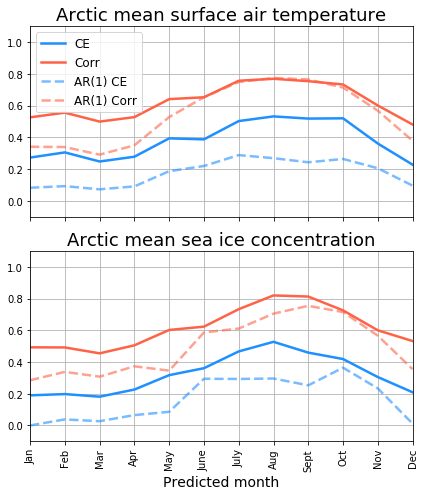

In [66]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig,ax = plt.subplots(len(varplot),1, figsize=(6,7),
                      sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    print(var)
    ax[n].plot(np.arange(1,13,1),ce_monthly[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', linewidth=2.5,label='CE')
    ax[n].plot(np.arange(1,13,1),corr_monthly[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', linewidth=2.5,label='Corr')
    
for n,var in enumerate(varplot): 
    ax[n].plot(np.arange(1,13,1),ce_mon_ar1[var+'_pm'][:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n].plot(np.arange(1,13,1),corr_mon_ar1[var+'_pm'][:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_title('Arctic mean s'+full_names[varplot[0]][1:], fontsize=18)
ax[1].set_title('Arctic mean s'+full_names[varplot[1]][1:], fontsize=18)

for n,var in enumerate(varplot):    
#    ax[n].set_ylabel(full_names[var], fontsize=14)
    ax[n].set_xticks(np.arange(1,13,1))
    ax[n].set_xticklabels(mlabels, rotation=90)

ax[-1].set_xlabel('Predicted month', fontsize=14)
    
for n in range(len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)

ax[0].legend(loc='upper left', fontsize=12)
plt.tight_layout()

#### Spatial Plots: 

In [42]:
mode = 0
lim.plot_map_vector(E[var_dict['var1']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[0]+' EOF '+str(mode+1))
plt.show()
lim.plot_map_vector(E[var_dict['var2']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[1]+' EOF '+str(mode+1))

KeyError: 'var1'

In [51]:
pltvar.min()

-0.11585897108291325

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


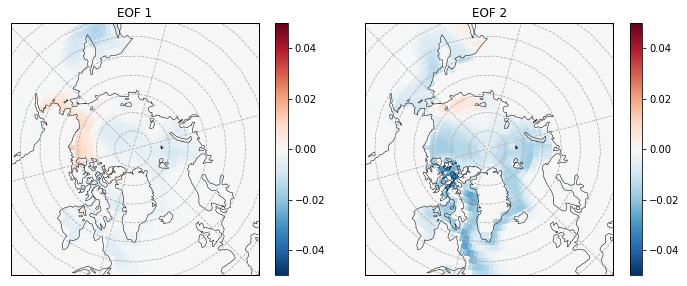

In [58]:
fig,ax = plt.subplots(1,2, figsize=(10,4), subplot_kw = arc_proj)
ax = ax.flatten()

pltvar = np.reshape(E_sic,(91,180,60))

lim.sub_arctic_plot(ax[0],fig,pltvar[:,:,0],lat_2d,lon_2d, minv=-0.05, 
                    maxv=0.05,cmap='RdBu_r')
lim.sub_arctic_plot(ax[1],fig,pltvar[:,:,1],lat_2d,lon_2d, minv=-0.05, 
                    maxv=0.05,cmap='RdBu_r')

#ax[1].scatter(lon_2d[0,0],lat_2d[84,0],s=30,color='m',transform=ccrs.PlateCarree())

ax[0].set_title('EOF 1')
ax[1].set_title('EOF 2')

plt.tight_layout()

save_name = ('ce_corr_spatial_lim_'+str(dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
#plt.savefig((save_dir+save_name),dpi=300)

In [59]:
var = 'sic'
lag = 1

ce_lalo = np.zeros((nlat*nlon))
corr_lalo = np.zeros((nlat*nlon))

truth_full = np.nan_to_num(np.reshape(truth_state[0][var+'_full'],
                                      (truth_state[0][var+'_full'].shape[0],nlat*nlon)))
forecast_full = np.nan_to_num(np.reshape(forecast[0][var+'_full'],
                                         (forecast[0][var+'_full'].shape[0],nlat*nlon)))

for s in range(nlat*nlon):
    ce_lalo[s] = LMR_utils.coefficient_efficiency(truth_full[lag:,s],
                                                  forecast_full[lag:,s])
    corr_lalo[s] = np.corrcoef(truth_full[lag:,s],
                               forecast_full[lag:,s])[0,1]

ce_2d = np.reshape(ce_lalo,(nlat,nlon))                           
corr_2d = np.reshape(corr_lalo,(nlat,nlon)) 

/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


In [60]:
lat_2d.shape

(91, 180)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


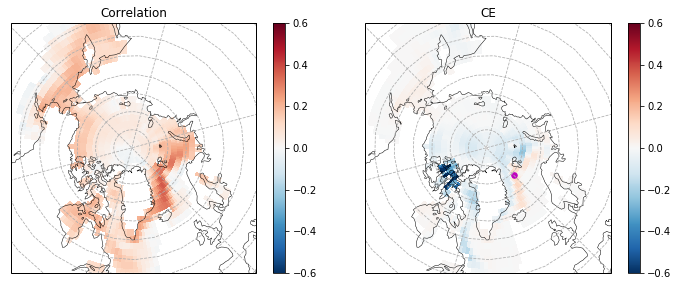

In [61]:
fig,ax = plt.subplots(1,2, figsize=(10,4), subplot_kw = arc_proj)
ax = ax.flatten()

lim.sub_arctic_plot(ax[0],fig,corr_2d,lat_2d,lon_2d, minv=-0.6, 
                    maxv=0.6,cmap='RdBu_r')
lim.sub_arctic_plot(ax[1],fig,ce_2d,lat_2d,lon_2d, minv=-0.6, 
                    maxv=0.6,cmap='RdBu_r')

ax[1].scatter(lon_2d[0,0],lat_2d[84,0],s=30,color='m',transform=ccrs.PlateCarree())

ax[0].set_title('Correlation')
ax[1].set_title('CE')

plt.tight_layout()

save_name = ('ce_corr_spatial_lim_'+str(dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
#plt.savefig((save_dir+save_name),dpi=300)

In [ ]:
lat_2d[80,0]

In [ ]:
plt.plot(truth_state[0]['sic_full'][:,84,0])
plt.plot(forecast[0]['sic_full'][:,84,0])

In [ ]:
X_valid[1,:,:].shape

In [ ]:
fields['sic'], 16380/4

In [ ]:
var = 'sit'
lag = 1

ce_lalo = np.zeros((nlat*nlon))
corr_lalo = np.zeros((nlat*nlon))

truth_full = np.nan_to_num(np.reshape(truth_state[0][var+'_full'],
                                      (truth_state[0][var+'_full'].shape[0],nlat*nlon)))
forecast_full = np.nan_to_num(np.reshape(forecast[0][var+'_full'],
                                         (forecast[0][var+'_full'].shape[0],nlat*nlon)))

for s in range(nlat*nlon):
    ce_lalo[s] = LMR_utils.coefficient_efficiency(truth_full[lag:,s],
                                                  forecast_full[lag:,s])
    corr_lalo[s] = np.corrcoef(truth_full[lag:,s],
                               forecast_full[lag:,s])[0,1]

ce_2d = np.reshape(ce_lalo,(nlat,nlon))                           
corr_2d = np.reshape(corr_lalo,(nlat,nlon)) 

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(10,4), subplot_kw = arc_proj)
ax = ax.flatten()

lim.sub_arctic_plot(ax[0],fig,corr_2d,lat_2d,lon_2d, minv=-0.2, 
                    maxv=0.2,cmap='RdBu_r')
lim.sub_arctic_plot(ax[1],fig,ce_2d,lat_2d,lon_2d, minv=-0.2, 
                    maxv=0.2,cmap='RdBu_r')

ax[0].set_title('Correlation')
ax[1].set_title('CE')

plt.tight_layout()

In [ ]:
for v,var in enumerate(limvars):
    forecast_3d = np.moveaxis(np.reshape(LIMfd_valid['x_forecast'][0,fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs = np.moveaxis(np.reshape(rmse[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs2 = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    var_error_rs2 = np.reshape(error_mon[fields[var],:].T, [12,nlat,nlon])
    rmse_lalo[var] = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    
    evar_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_error_rs,lat_2d[:,0])
    rmse_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_rmse_rs,lat_2d[:,0])
    rmse_mon_pm[var] = lim.polar_regional_means(var_rmse_rs2,lat_2d[:,0],lon_2d[0,:])
    evar_mon_pm[var] = lim.polar_regional_means(var_error_rs2,lat_2d[:,0],lon_2d[0,:])

In [ ]:
[error_all_mon, 
 error_mon, rmse,
time_ermon] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                             truth,E,LIMfd_valid['time_forecast'],
                                             len(limvars),ndof,
                                             E_sic,nmodes,sic_separate=sic_separate)
[error_all_mon_eof, 
 error_mon_eof, rmse_eof, 
 time_ermon2] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                               truth, E,LIMfd_valid['time_forecast'],
                                               len(limvars),ndof,
                                               E_sic,nmodes,sic_separate=sic_separate)
rmse2 = np.mean(error_all_mon**2,axis=2)

evar_mon_gm = {}
rmse_mon_gm = {}
evar_mon_pm = {}
rmse_mon_pm = {}
rmse_lalo = {}

for v,var in enumerate(limvars):
    var_error_rs = np.moveaxis(np.reshape(error_mon[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs = np.moveaxis(np.reshape(rmse[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs2 = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    var_error_rs2 = np.reshape(error_mon[fields[var],:].T, [12,nlat,nlon])
    rmse_lalo[var] = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    
    evar_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_error_rs,lat_2d[:,0])
    rmse_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_rmse_rs,lat_2d[:,0])
    rmse_mon_pm[var] = lim.polar_regional_means(var_rmse_rs2,lat_2d[:,0],lon_2d[0,:])
    evar_mon_pm[var] = lim.polar_regional_means(var_error_rs2,lat_2d[:,0],lon_2d[0,:])

In [ ]:
# compute errors in both the EOF space and full grid point space
err,err_gm = lim.LIM_forecast_error(LIMfd_valid,truth,E,lags,fields,lat_2d,
                                    E_sic,nmodes,sic_separate=sic_separate)

# err_eofs,err_gm_eofs = lim.LIM_forecast_error(LIMfd_valid,np.real(np.matmul(E,x_valid)),
#                                               E,lags,fields,lat_2d,E_sic,nmodes,
#                                               sic_separate=sic_separate)

In [ ]:
LIMfd_valid['x_forecast'].shape, truth.shape

In [ ]:
color_list = ['crimson','b','m','c','orange','k']

for n,var in enumerate(limvars): 
    plt.plot(lags,err_gm[n,:]/valid_variance_full[var+'_gm'],
             color=color_list[n],linestyle='-',label=var+' valid')
#     plt.plot(lags,err_gm_eofs[n,:]/valid_variance_eof[var+'_gm'],
#              color=color_list[n],linestyle='--',label=list(fields.keys())[n]+' valid eofs')

plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized global error variance')

In [ ]:
valid_variance_full.keys()

In [ ]:
evar_mon_pm['sic'].shape

In [ ]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),evar_mon_gm['tas']/valid_variance_full['tas_gm'],
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),evar_mon_pm['sic'][0,:]/valid_variance_full['sic_polarm_mon'][0,:],
         color='b',label='sic Arctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized error variance')

In [ ]:
#color_list = ['crimson','b']
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),rmse_mon_gm['tas']/np.sqrt(valid_variance_full['tas_gm_mon']),
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),rmse_mon_pm['sic'][0,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][0,:]),
         color='b',label='sic Arctic (60N)')
plt.plot(range(12),rmse_mon_pm['sic'][1,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][1,:]),
         color='b',linestyle='--',label='sic Antarctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('Normalized RMSE')
#plt.ylim(0.7,1.01)
plt.legend()
plt.title('LIM performance by month')

In [ ]:
fig,ax = plt.subplots(4,3, figsize=(8,9), subplot_kw = arc_proj)
ax = ax.flatten()

for m in range(12):
    lim.sub_arctic_plot(ax[m],fig,rmse_lalo['sic'][m,:,:]/np.sqrt(valid_variance_full['sic_mon_lalo'][:,:,m]),
                        lat_2d,lon_2d, minv=0.5, maxv=1,cmap='YlGnBu')
    ax[m].set_title(mlabels[m])

plt.tight_layout()

# plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
#              '_error_arctic_spatial_plots_randtime_eof'+str(nmodes)+'_tau'+
#              str(tau)+'_'+today_date+'.png'),dpi=300)

In [ ]:
sic_rmse.shape

In [ ]:
# plot the coupled EOFs
mode = 0
lim.plot_map_vector(E[var_dict['var1']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[0]+' EOF '+str(mode+1))
plt.show()
lim.plot_map_vector(E[var_dict['var2']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[1]+' EOF '+str(mode+1))

In [ ]:
LIMd['vec'].shape

In [ ]:
fields

In [ ]:
var1_inds

In [ ]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

In [ ]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

In [ ]:
plot_map_vector(X_nonan_arctic[:,800].data,lat_2d,lon_2d)

In [ ]:
X_nonan_arctic_mon = np.reshape(X_nonan_arctic,(3240,1001,12))
X_arctic_FMA = X_nonan_arctic_mon[:,:,1:4].reshape(3240,3003) 
X_arctic_ASO = X_nonan_arctic_mon[:,:,7:10].reshape(3240,3003) 

X_arctic_FMA_anom = X_arctic_FMA - np.nanmean(X_arctic_FMA,axis=1)[:,np.newaxis]
X_arctic_ASO_anom = X_arctic_FMA - np.nanmean(X_arctic_ASO,axis=1)[:,np.newaxis]

In [ ]:
var.shape, W.shape, X_check.shape

In [ ]:
var = X_nonan_arctic_mon[:,:,2] - np.nanmean(X_nonan_arctic_mon[:,:,2],axis=1)[:,np.newaxis]
u,s,v,W = calc_eof(var, lat_2d)

# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*var))

In [ ]:
plot_eigenvalues(s,var_to_extract)

In [ ]:
plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [ ]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,var)

In [ ]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

plot_map_vector(var[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()

In [ ]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [ ]:
ntrain = 500

In [ ]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

In [ ]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [ ]:
nt = x_train.shape[1]
C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)
tau

In [ ]:
C1_phys_space = np.matmul(C_1,E.T)

plot_map_vector(C1_phys_space[0,:],lat_2d,lon_2d,maxv=3)
plt.title('lagged_covariance')
plt.show()

In [ ]:
tau = 1

In [ ]:
# train the LIM
LIMd = LIM_train(tau,x_train)

In [ ]:
lags

In [ ]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(4)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = LIM_forecast(LIMd,x_valid,lags,E)

In [ ]:
LIMfd_train.keys()

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)

In [ ]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime],lat_2d,lon_2d,minv=-4,maxv=4)
plt.title('True state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()

In [ ]:
forecast_state_train = np.matmul(E,LIMfd_train['x_forecast']) 
true_state_train = X_arctic_FMA[:,train_inds]
true_state_train.shape, forecast_state_train.shape

In [ ]:
initialt = 1
plt.plot(np.arange(0,13,1),true_state_train[3200,initialt:initialt+13], label='truth')
plt.plot(np.arange(0,13,1),forecast_state_train[:,3200,initialt], label='forecast')
plt.legend()

r = np.zeros(4000-12)

for it in range(4000-12):
    r[it] = np.corrcoef(true_state_train[3000,it:it+13],forecast_state_train[:,3000,it])[0,1]

In [ ]:
plt.plot(r)
#plt.xlim(3900,4000)
r.mean()

In [ ]:
LIMfd_train.keys(), x_valid.shape, E.shape, lags

In [ ]:
LIMfd_train['x_truth_phys_space'].shape,LIMfd_train['x_forecast_phys_space'].shape, LIMfd_train['error'].shape, LIMfd_train['x_forecast'].shape

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_truth_3d = np.reshape(LIMfd_train['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_train_forecast_3d = np.reshape(LIMfd_train['x_forecast_phys_space'],[nlat,nlon,3988])
LIMfd_valid_truth_3d = np.reshape(LIMfd_valid['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_valid_forecast_3d = np.reshape(LIMfd_valid['x_forecast_phys_space'],[nlat,nlon,3988])

[train_truth_gm,
 train_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_truth_3d,lat_2d[:,0])
[train_forecast_gm,
 train_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_forecast_3d,lat_2d[:,0])
[valid_truth_gm,
 valid_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_truth_3d,lat_2d[:,0])
[valid_forecast_gm,
 valid_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_forecast_3d,lat_2d[:,0])



## Independent validation: 

In [ ]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

In [ ]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [ ]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

In [ ]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)